This is a notebook to run ML inference on all 6 months of spire data using the trained xgboost model

* 6 months of spire data feature sets created by `/scripts/make_feature_sets_all_data.py`
* feature sets at `/data/feature_sets_all/`
* Model created by `/notebooks/ml-pipeline.multi.ipynb`
* Model stored at `/models4-multi-class_xgb-model.joblib` 


Goals:
* characterize 6 months of data
* Iono
    * distribution
    * detection in presense of RFI

* RFI
    * distribution of downlinks
        * detection of RFI in downlinks
    * distribution of RFI not during downlink

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
from sklearn.decomposition import PCA
import argparse
import pandas as pd

import sys  
sys.path.insert(1, '/home/stdi2687/leo-ml/scripts')

from feature_extract_util import *
from ml_util import *

In [2]:
from matplotlib.patches import Rectangle
def plot_leo_ml_multi(sample, ds, lv2, y_pred, times, labels):

    c=299792458 #m/s
    #iono_free=((ds.scnfreq1**2)*(c/ds['exL1'])-(ds.scnfreq2**2)*(c/ds['exL2']))/(ds.scnfreq1**2-ds.scnfreq2**2)
    
    #ku=40.3*1e16
    #dTEC=(ds['exL2']-ds['exL1'])/(ku*(1/ds.scnfreq1**2-1/ds.scnfreq2**2))
    fig,ax=plt.subplots(6, figsize=(8,8),sharex=True)
    ax[0].set_title(sample)

    for freq,snr,color in zip([1,2],['caL1Snr','pL2Snr'],['#1b9e77','#d95f02']): 
        ax[0].plot(ds[snr].time+ds.startTime, ds[snr].values, alpha=.5, color=color, label='L%s'%freq)
        ax[0].set_ylabel('SNR' "\n" '(v/v)')

        ax[1].plot(lv2['s4_L%s'%freq].time+lv2.startTime, lv2['s4_L%s'%freq].values, color=color)
        ax[1].set_ylabel('S4')
        
        #ax[1].plot(ds['raw_exL%s'%freq].time, ds['raw_exL%s'%freq].values, color=color, label='L%s'%freq)
        #ax[1].set_ylabel(r'$\delta \phi$ (cycles)')
        ax[4].plot(lv2['elevation'].time+lv2.startTime, lv2['elevation'].values, color='black')
        ax[4].set_ylabel('elevation')
        ax2=ax[4].twinx()
        ax2.plot(ds['occheight'].time+ds.startTime, ds['occheight'].values, color='tab:orange')
        ax2.set_ylabel('occ height', color='tab:orange')

            
        ax[2].plot(ds['exL%s'%freq].time+ds.startTime, ds['exL%s'%freq].values, color=color, label='L%s'%freq)
        ax[2].set_ylabel(r'$\delta \phi$' "\n" '(m)')

        ax[3].plot(lv2['sigma_phi_L%s'%freq].time+lv2.startTime, lv2['sigma_phi_L%s'%freq].values, color=color)
        ax[3].set_ylabel(r'$\sigma \phi$' "\n" '(m)')
    #ax[3].plot(dTEC.time, dTEC.values)
    
    #ax[3].set_ylabel(r'$\Delta TEC$' "\n" '(TECU)')
    
    #ax[4].plot(iono_free.time, iono_free.values)
    #ax[4].set_ylabel('iono-free' "\n" '(m)')
    ax[0].legend(ncol=2)
    '''
    ## plot ml results
    df=pd.read_pickle('/home/kawu4468-copy/data_mat/spire_iq/rf_ml_ro.pkl')
    colors=['#e7298a','#d95f02','#7570b3','#1b9e77','#1b9e77','#66a61e','#e6ab02'] ##1b9e77
    labels=['scint', 'OA', 'dual int', 'quiet', 'quiet', 'l1 int', 'l2 int']
    fn_arr='scnPhs_%s.0001_ex.mat' %sample
    df=df[df.file==fn_arr]
    print(df['sample'])
    print(df.y_pred)
    [ax[5].add_patch(Rectangle((ds.time.min()+i*15, 0), 15, 1, alpha=.75, color= ,  label=labels[y-1])) for i, y in list(zip(df['sample'], df.y_pred))]
    '''
    
    for valz, labz, colz in zip (np.arange(6),labels,['#e41a1c','white','#4daf4a','#984ea3','#ff7f00','#ffff33']): #377eb8
        #[ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=1, label='No Scint', color="white")) for i in times[y_pred==0]]
        [ax[5].axvline(i) for i in times]
        [ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=.75, label=labz, color=colz)) for i in times[y_pred==valz]]
    
    handles,labels_=ax[5].get_legend_handles_labels() #get existing legend item handles and labels
    by_label = dict(zip(labels_, handles))
    ax[5].legend(by_label.values(), by_label.keys(), ncol=4, loc='lower left')
    ax[5].get_yaxis().set_ticks([])
    ax[5].set_ylabel('RF Class')

    ax[5].set_xlim([times.min(), times.max()])

    #ax2=ax[5].twinx()
    #ax2.plot(ds['RFI'].orbtime-ds['RFI'].orbtime[0]+ds.startTime, ds['RFI'].values, color='tab:orange')
    #ax2.plot(hour_init+(ds['RFI'].orbtime-ds.startTime.values[0])/3600, ds['RFI'].values)
    #ax2.set_ylabel('RFI')
    #plt.savefig("../figures/results/%s.png" %sample, dpi=300)

def load_plot_multi(sample):
    labels=['Scint','Quiet','RFI','Artifact','Severe Scint'] #'oa',

    sample=sample[:-4]

    #feature_pkl='../data/feature_sets_all/%s.pkl' %sample
    import os.path
    fn='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
    lv1=load_leo(fn)
    fn='/media/datastore/mirror/spwxdp/repro4/spire/level2/scnLv2/%s/scnLv2_%s.0001_nc'%(sample[:8],sample)
    lv2=load_leo(fn)

    #plot_leo(sample, sp, lv2)
    fdf=extract_fs(lv1,lv2)
    fdf['sample']=len(fdf)*[sample]


    X, y, feature_names, fs_dict=df_2_Xy(fdf)
    #--- test model
    y_pred = rf_model.predict(X)

    plot_leo_ml_multi(sample, lv1, lv2, y_pred, fs_dict['time'], labels)

def map_condition(lons, lats, y_pred, condition_val):
    #https://medium.com/@kavee625/plotting-data-on-the-world-map-with-geopandas-f03742615196
  import matplotlib.pyplot as plt
  import geopandas as gpd
  #from cartopy import crs as ccrs
  # Getting world map data from geo pandas
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

  # Creating axes and plotting world map
  fig, ax = plt.subplots(figsize=(16, 10))
  worldmap.plot(color="lightgrey", ax=ax)

  #robinson = ccrs.Robinson().proj4_init
  #worldmap.to_crs(robinson).plot(color="lightgrey", ax=ax)

  # Plotting tourist source markets
  x = lons[y_pred==condition_val]
  y = lats[y_pred==condition_val]
  #z = df['spireid']
  plt.scatter(x, y, 
                s=0.2,#*z,
                c='b',
                alpha=0.3,             
                cmap='autumn'
              )
  #plt.colorbar(label='Number of tourists')

  # Creating axis limits and title
  plt.xlim([-180, 180])
  plt.ylim([-90, 90])

  #plt.title("Tourist arrivals from main countries to Sri Lanka\n  Year : 2021")
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.show()

In [13]:


'''
#list all files
def list_all_files(parent_directory):
    file_list = []
    for root, dirs, files in os.walk(parent_directory):
        for file in files:
            file_list.append(file)
    return file_list

parent_directory = '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs'
all_files = list_all_files(parent_directory)

print(len(all_files))
'''
#list all feature sets

parent_directory = '/home/stdi2687/gnss-leo-data/data/feature_sets_all'
all_files_f = os.listdir(parent_directory)

print(len(all_files_f))
print(all_files_f[:2])


fdf_li=[]
for filez in all_files_f[:]:
    #print(row['c1'], row['c2'])
    fn="../data/feature_sets_all/%s" %filez
    fn="../data/feature_sets_all_v2/%s" %filez
    sample=filez[:-4]
    #print(fn)
    
    try:
        if filez[:]
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        fdf_li+=[fdf]
    except:
        pass
all_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

#X, y, times, lats, occ_hts, feature_names =df_2_Xy(all_fdf)
#X, y, feature_names, fs_dict=df_2_Xy(all_fdf)

54966
['2023.104.122.08.01.R07.SC001_0001.pkl', '2022.310.129.14.01.G31.SC001_0001.pkl']


In [3]:
#save for later
#all_fdf.to_pickle('../data/feature_set_all_single_file/all_fdf_v2.pkl')

#read later
all_fdf=pd.read_pickle('../data/data/feature_set_all_single_file/all_fdf_v2.pkl')
#X, y, times, lats, lons, occ_hts, feature_names =df_2_Xy(all_fdf)
X, y, feature_names, fs_dict=df_2_Xy(all_fdf)

parent_directory = '/home/stdi2687/gnss-leo-data/data/feature_sets_all'
all_files_f = os.listdir(parent_directory)

In [49]:
len(np.unique(fs_dict['sample']))

54258

In [5]:
version="4-multi-class"
version="6"
version="7"
version="9"
from joblib import dump, load
model=load( '../models/%s_xgb-model.joblib' %version)


#--- test model
y_pred = model.predict(X)
#print(y_pred)
unique, counts = np.unique(y_pred, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

{0: 188029, 1: 396048, 2: 20162, 3: 16258, 4: 31243, 5: 12215}


In [6]:
for keyz in list(count_dict.keys()):
    print('label',keyz, ':', count_dict[keyz]/len(y_pred))

label 0 : 0.28319539727843
label 1 : 0.5964982566589603
label 2 : 0.03036651580302882
label 3 : 0.024486599242418538
label 4 : 0.047055899872732336
label 5 : 0.018397331144429967


# filter triggered vs campaign

In [7]:
campaign_ind=[i for i, si in enumerate(fs_dict['sample']) if si.startswith("2023.14")]

# Lists for Ann

In [8]:
fs_df=pd.DataFrame(fs_dict)
fs_df['y_pred']=y_pred

In [19]:
#overall:
fs_df[y_pred==2].drop_duplicates(subset='sample', keep="first").to_csv('../data/rfi_labels_all.csv', index=False)
fs_df[y_pred==0].drop_duplicates(subset='sample', keep="first").to_csv('../data/scint_labels_all.csv', index=False)
fs_df[y_pred==5].drop_duplicates(subset='sample', keep="first").to_csv('../data/comms_labels_all.csv', index=False)

#campaign profiles
print("CAMPAIGN")
camp_df=fs_df.iloc[campaign_ind]
camp_y=y_pred[campaign_ind]

unique, counts = np.unique(camp_y, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

for keyz in list(count_dict.keys()):
    print('label',keyz, ':', count_dict[keyz]/len(camp_y))

camp_df[camp_y==2].drop_duplicates(subset='sample', keep="first").to_csv('../data/rfi_labels_camp.csv', index=False)
camp_df[camp_y==0].drop_duplicates(subset='sample', keep="first").to_csv('../data/iono_labels_camp.csv', index=False)
camp_df[camp_y==5].drop_duplicates(subset='sample', keep="first").to_csv('../data/comms_labels_camp.csv', index=False)


#profile level stats
#comms count
comms_li=list(camp_df[camp_y==5].drop_duplicates(subset='sample', keep="first")['sample'].values)
rfi_li=list(camp_df[camp_y==2].drop_duplicates(subset='sample', keep="first")['sample'].values)
#Hierarchy, only count each profile once
# #list(set(list_2).difference(list_1))
rfi_li=list(set(rfi_li).difference(comms_li))

iono_li=list(camp_df[camp_y==0].drop_duplicates(subset='sample', keep="first")['sample'].values)
iono_li=list(set(iono_li).difference(comms_li+rfi_li))

total_li=camp_df.drop_duplicates(subset='sample', keep="first")['sample'].values

print('campaign comms',len(comms_li)/len(total_li))
print('campaign rfi',len(rfi_li)/len(total_li))
print('campaign iono',len(iono_li)/len(total_li))


# triggered profiles
print("TRIGGER")
trigger_df=fs_df.drop(index=campaign_ind)
mask = np.ones(y_pred.size, dtype=bool)
mask[campaign_ind] = False
trigger_y=y_pred[mask]

unique, counts = np.unique(trigger_y, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

for keyz in list(count_dict.keys()):
    print('label',keyz, ':', count_dict[keyz]/len(trigger_y))

trigger_df[trigger_y==2].drop_duplicates(subset='sample', keep="first").to_csv('../data/rfi_labels_trig.csv', index=False)
trigger_df[trigger_y==0].drop_duplicates(subset='sample', keep="first").to_csv('../data/iono_labels_trig.csv', index=False)
trigger_df[trigger_y==5].drop_duplicates(subset='sample', keep="first").to_csv('../data/comms_labels_trig.csv', index=False)

#profile level stats
#comms count
comms_li=list(trigger_df[trigger_y==5].drop_duplicates(subset='sample', keep="first")['sample'].values)
rfi_li=list(trigger_df[trigger_y==2].drop_duplicates(subset='sample', keep="first")['sample'].values)
#Hierarchy, only count each profile once
# #list(set(list_2).difference(list_1))
rfi_li=list(set(rfi_li).difference(comms_li))

iono_li=list(trigger_df[trigger_y==0].drop_duplicates(subset='sample', keep="first")['sample'])
iono_li=list(set(iono_li).difference(comms_li+rfi_li))

total_li=trigger_df.drop_duplicates(subset='sample', keep="first")['sample']

print('trigger comms',len(comms_li)/len(total_li))
print('trigger rfi',len(rfi_li)/len(total_li))
print('trigger iono',len(iono_li)/len(total_li))

CAMPAIGN
{0: 8326, 1: 108451, 2: 1606, 3: 802, 4: 226, 5: 327}
label 0 : 0.0695351517479831
label 1 : 0.9057358566202877
label 2 : 0.013412617548313818
label 3 : 0.006697957206567673
label 4 : 0.001887454275167449
label 5 : 0.0027309626016803353
campaign comms 0.024108003857280617
campaign rfi 0.07232401157184185
campaign iono 0.4038894246223079
TRIGGER
{0: 179703, 1: 287597, 2: 18556, 3: 15456, 4: 31017, 5: 11888}
label 0 : 0.3302046793834077
label 1 : 0.5284601546809453
label 2 : 0.03409669304707497
label 3 : 0.028400435855550268
label 4 : 0.056993809454684435
label 5 : 0.021844227578337316
trigger comms 0.10032059288866683
trigger rfi 0.15369722707969022
trigger iono 0.5289158131401449


In [55]:
print(len(camp_y))
print(len(trigger_y))

119738
544217


In [56]:
# plot rates for different data regimes

# Maps

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


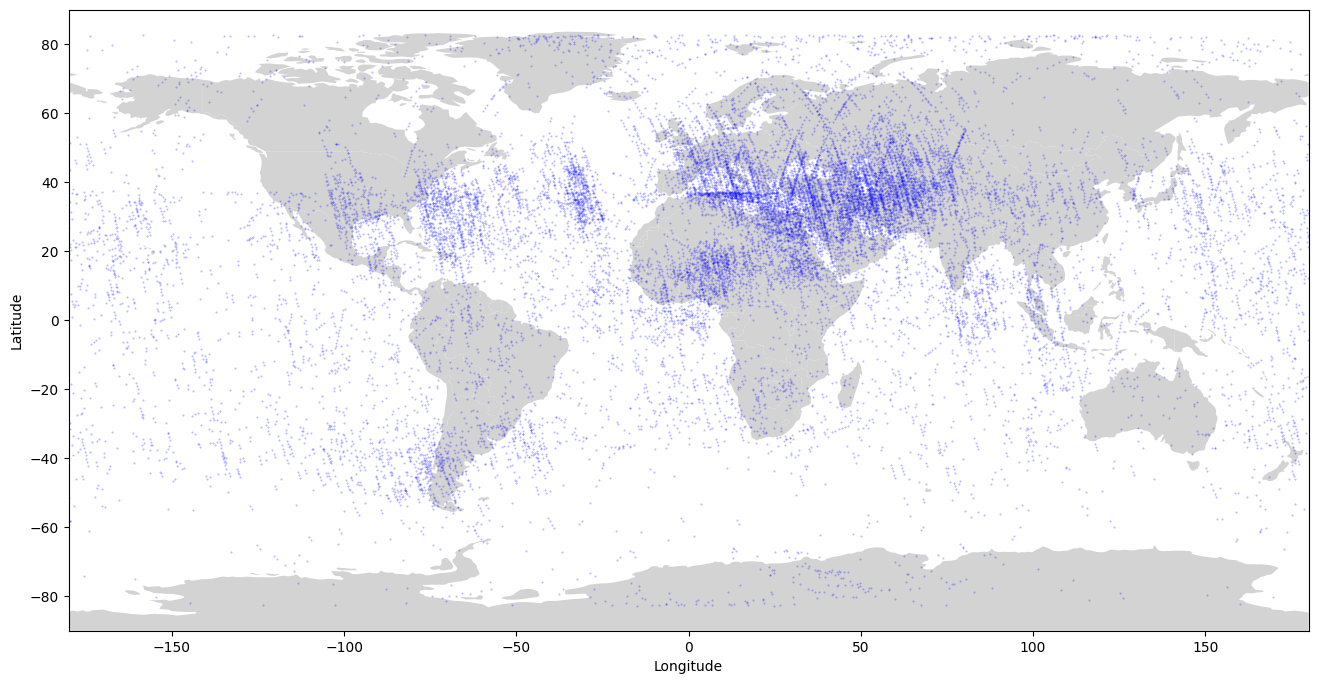

In [24]:
map_condition(fs_dict['lon_m'], fs_dict['lat_m'], y_pred, 2)

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


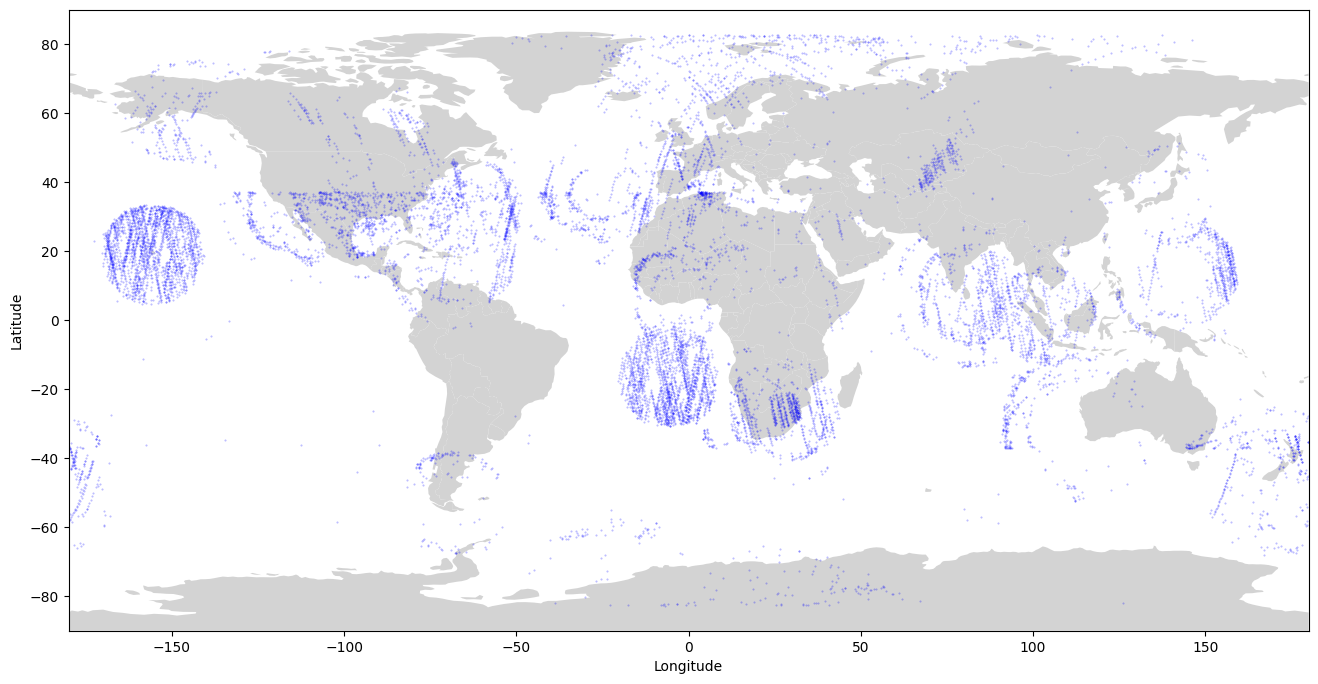

In [30]:
map_condition(fs_dict['lon_m'][mask], fs_dict['lat_m'][mask], trigger_y, 5)

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


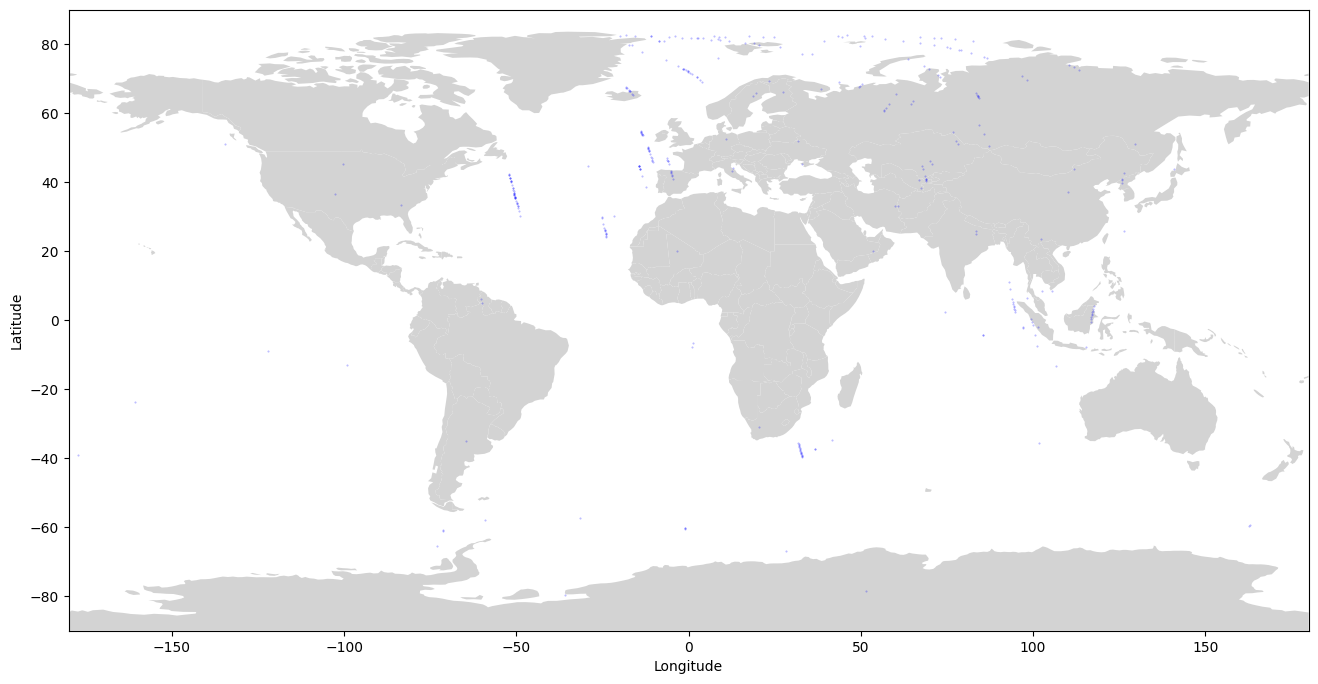

In [29]:
map_condition(fs_dict['lon_m'][campaign_ind], fs_dict['lat_m'][campaign_ind], camp_y, 5)

In [24]:
# For all Downlinks, count occurence of RFI (ability to detect downlink)
# For all downlinks, count occurence of iono (ability to do science during DL)

In [15]:
consat_df=pd.read_pickle("../data/consat_df.pkl")

In [16]:
len(consat_df.spire_id.unique())

27

In [17]:
#generate list of comms link profiles
comms_file_li=[]

for index, row in consat_df.iloc[:].iterrows():
    start_t=row['start']
    end_t=row['end']
    spireid=row['spire_id']
    contacttype=row['contact_type']
    #gnssid=
    row=row.drop('sum_all')
    idx_sv=row.iloc[4:].gt(0)
    for idx,val in row.iloc[4:][idx_sv].iteritems():
        #print(idx, val)
        gnssid=idx
        
        sample='%s.%03d.%s.%02d.01.%s.SC001_0001' %(start_t.year,start_t.day_of_year,spireid, start_t.hour,gnssid)
        #sample='2023.144.103.01.01.E33.SC001_0001'
        fn1='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
        #either 01 or 02
        if not os.path.isfile(fn1):
            sample='%s.%03d.%s.%02d.02.%s.SC001_0001' %(start_t.year,start_t.day_of_year,spireid, start_t.hour,gnssid)
            fn1='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
            if not os.path.isfile(fn1):
                continue
        comms_file_li.append('%s'%sample +'.pkl')

#drop duplicates
comms_file_li=list(set(comms_file_li))


In [18]:
len(comms_file_li)

11701

# check Downlink Windows

In [23]:
rfi_count=0
iono_rfi_count=0
scint_count=0
iono_rfi_li=[]
fdf_li=[]
comms_fdf_li=[]
for filez in comms_file_li[:]:
    #print(row['c1'], row['c2'])
    fn="../data/data/feature_sets_all_v2/%s" %filez
    #print(fn)
    
    try:
        comms_fdf=pd.read_pickle(fn)
       
        if comms_fdf.shape[1]==69:
            comms_fdf['sample']=len(comms_fdf)*[sample]
            #X, y, times, lats, lons, occ_hts, feature_names =df_2_Xy(comms_fdf)
            X, y, feature_names, fs_dict=df_2_Xy(comms_fdf)

            #--- test model
            y_pred = rf_model.predict(X)

            # Was RFI detected during downlink? count
            if 2 in y_pred: 
                #print("exist")
                rfi_count+=1
                # Was IONO detected NEXT TO RFI?
                if 0 in y_pred:  #list contains both
                    #print(y_pred)
                    for i,element in enumerate(y_pred): #now loop through list
                        if i==0:
                            if (element==0 and (y_pred[i+1]==2)):
                                iono_rfi_count+=1
                                iono_rfi_li.append(filez)
                                continue #don't check the same array twice
                        if i==(len(y_pred)-1):
                            if (element==0 and (y_pred[i-1]==2)):
                                iono_rfi_count+=1
                                iono_rfi_li.append(filez)
                                continue #don't check the same array twice
                        if (i<=(len(y_pred)-2) and i!=0):
                            #print(i,len(y_pred))
                            if (element==0 and (y_pred[i-1]==2 or y_pred[i+1]==2)):
                                iono_rfi_count+=1
                                iono_rfi_li.append(filez)
                                continue #don't check the same array twice
            # Was scint detected during downlink at all?
            if 0 in y_pred:
                scint_count+=1
            comms_fdf_li+=[comms_fdf]
        else:
            print(fn, comms_fdf.shape[1])
        #print(i)
    except Exception as e:
        print(e)
        pass
#all_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

#X, y, times, lats, occ_hts, feature_names =df_2_Xy(all_fdf)

(12, 69)
(12, 69)
(20, 69)
(13, 69)
(9, 69)
(10, 69)
(9, 69)
(4, 69)
(10, 69)
(10, 69)
(15, 69)
(13, 69)
(9, 69)
(17, 69)
(11, 69)
(3, 69)
(15, 69)
(3, 69)
(17, 69)
(13, 69)
(15, 69)
(12, 69)
(3, 69)
(17, 69)
(16, 69)
(13, 69)
(19, 69)
(12, 69)
(17, 69)
(9, 69)
(12, 69)
(9, 69)
(9, 69)
(20, 69)
(13, 69)
Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by StandardScaler.
(10, 69)
(18, 69)
(24, 69)
(10, 69)
(22, 69)
(11, 69)
(12, 69)
(27, 69)
(11, 69)
(22, 69)
(13, 69)
(14, 69)
(17, 69)
(9, 69)
(14, 69)
(14, 69)
(19, 69)
(11, 69)
(11, 69)
(9, 69)
(12, 69)
(11, 69)
(16, 69)
(21, 69)
(16, 69)
(4, 69)
(14, 69)
(12, 69)
(13, 69)
(21, 69)
(12, 69)
(10, 69)
(19, 69)
(28, 69)
(19, 69)
(10, 69)
(12, 69)
(24, 69)
(3, 69)
(19, 69)
(8, 69)
(4, 69)
(17, 69)
(14, 69)
(24, 69)
(3, 69)
(15, 69)
(18, 69)
(10, 69)
(15, 69)
(15, 69)
(3, 69)
(11, 69)
(28, 69)
(20, 69)
(3, 69)
(4, 69)
(9, 69)
(10, 69)
(10, 69)
Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is 

In [24]:
iono_rfi_count

124

In [25]:
scint_count

4753

In [26]:
print(iono_rfi_count/len(comms_file_li))
print(rfi_count/len(comms_file_li)) 
print(scint_count/len(comms_file_li))

0.010597384838902657
0.3301427228442014
0.4062045978976156


0.3327066062729681

In [7]:
len(comms_file_li)

11701

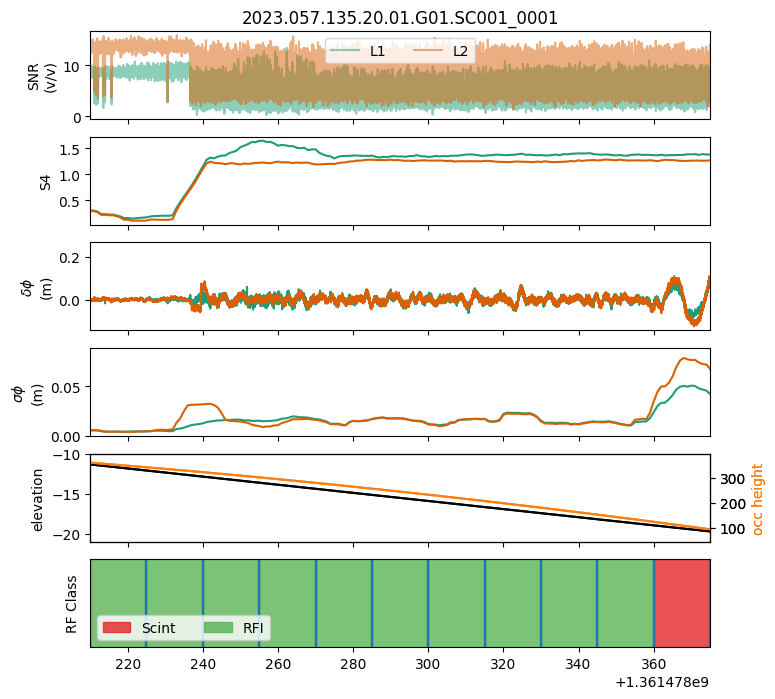

In [27]:
load_plot_multi(iono_rfi_li[2])

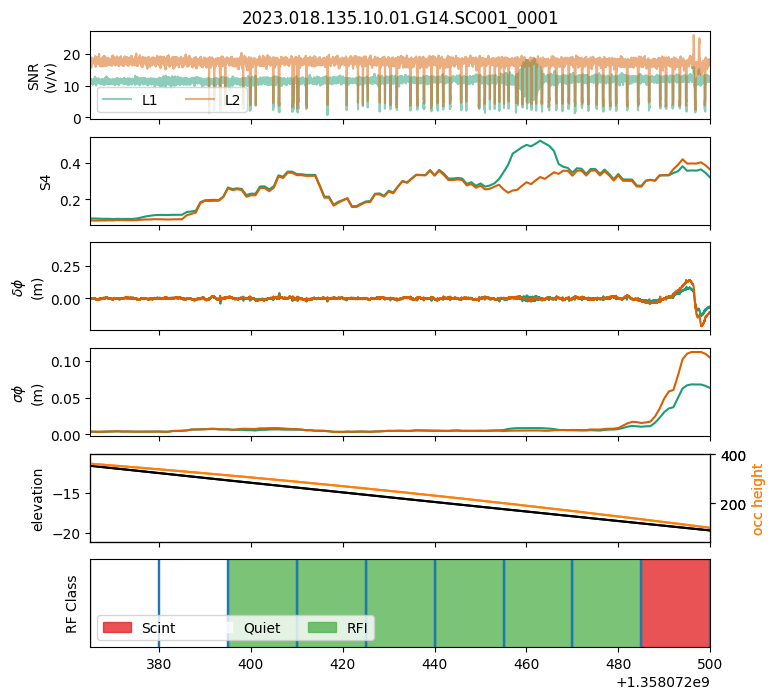

In [28]:
load_plot_multi(iono_rfi_li[52])

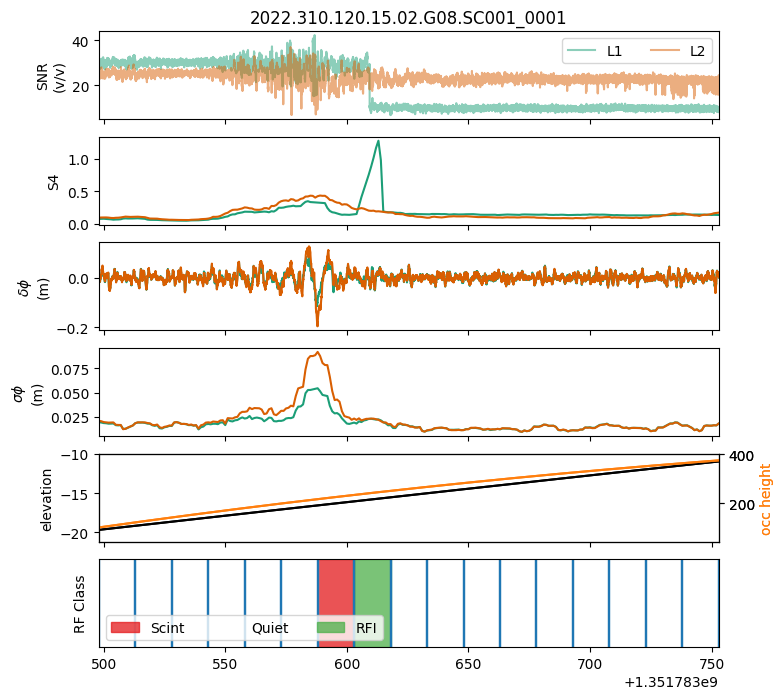

In [29]:
load_plot_multi(iono_rfi_li[56])

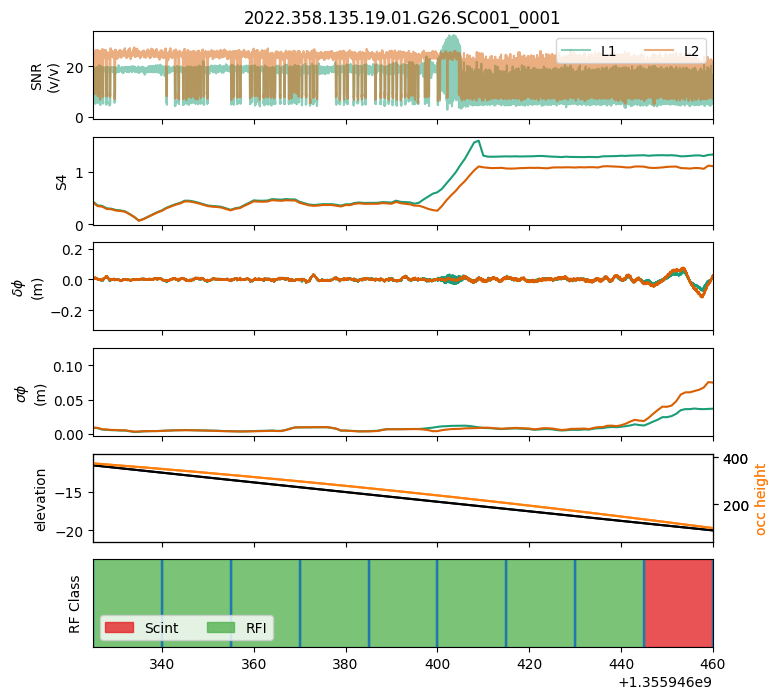

In [30]:
load_plot_multi(iono_rfi_li[3])

# for all non-downlink windows, count occurence of RFI

In [31]:
#Create list of all profiles, drop dups
all_files_list=list(set(all_files_f))

#list of all profiles used in training (to remove)

#list of all downlink profiles comms_file_li
#drop duplicates
comms_file_li=list(set(comms_file_li))

rfi_no_dl = list(set(all_files_list) - set(comms_file_li))


In [40]:
fdf_li=[]
for filez in rfi_no_dl[:]:
    #print(row['c1'], row['c2'])
    fn="../data/data/feature_sets_all_v2/%s" %filez
    #print(fn)
    
    try:
        fdf=pd.read_pickle(fn)
        if fdf.shape[1]==69:
            fdf['sample']=len(fdf)*[sample]
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
all_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

X, y, feature_names, fs_dict=df_2_Xy(all_fdf)

version="8"
from joblib import dump, load
rf_model=load( '../models/%s_rf-model.joblib' %version)


#--- test model
y_pred = rf_model.predict(X)
#print(y_pred)
unique, counts = np.unique(y_pred, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

{0.0: 121766, 1.0: 347986, 2.0: 3819, 3.0: 3990, 4.0: 33424}


In [41]:
len(y_pred)

510985

In [42]:
for keyz in list(count_dict.keys()):
    print('label',keyz, ':', count_dict[keyz]/len(y_pred))

label 0.0 : 0.2382966231885476
label 1.0 : 0.6810102057790346
label 2.0 : 0.007473800600800415
label 3.0 : 0.007808448388895956
label 4.0 : 0.0654109220427214


In [34]:
sum(y_pred==2)/len(y_pred)

0.012196330029310818

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


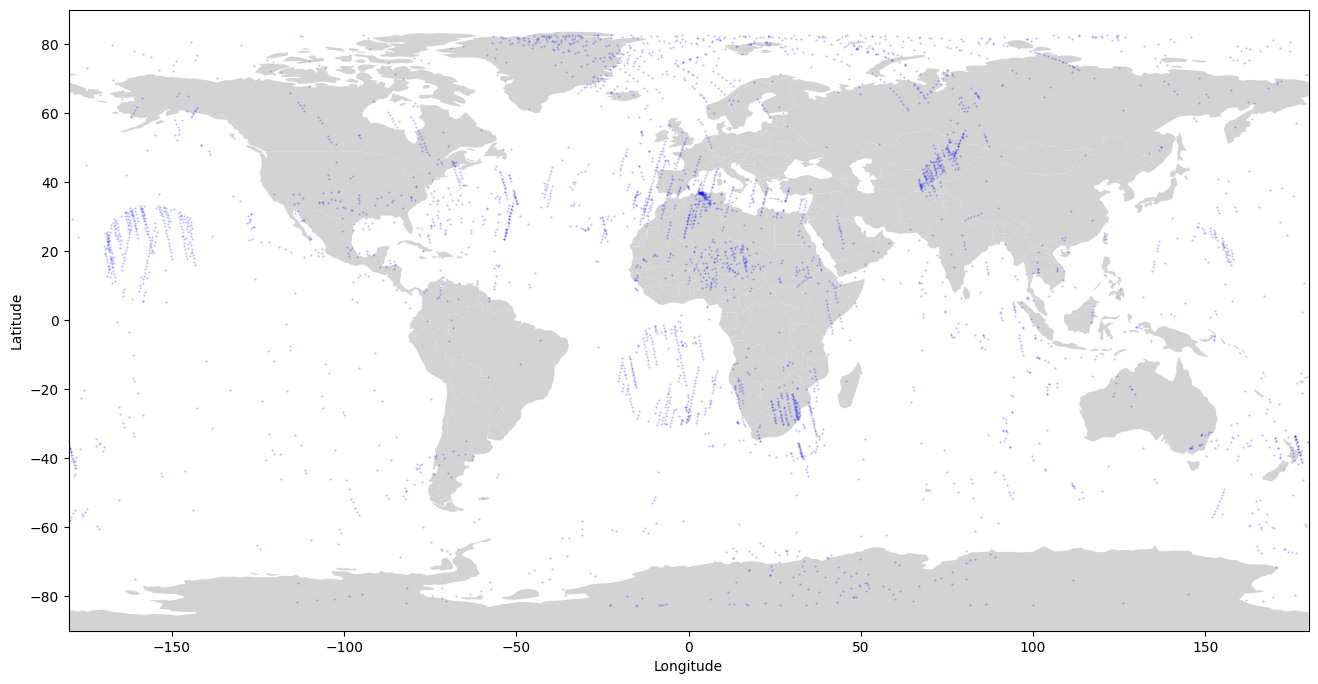

In [43]:
map_condition(fs_dict['lon_m'], fs_dict['lat_m'], y_pred, 2)

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


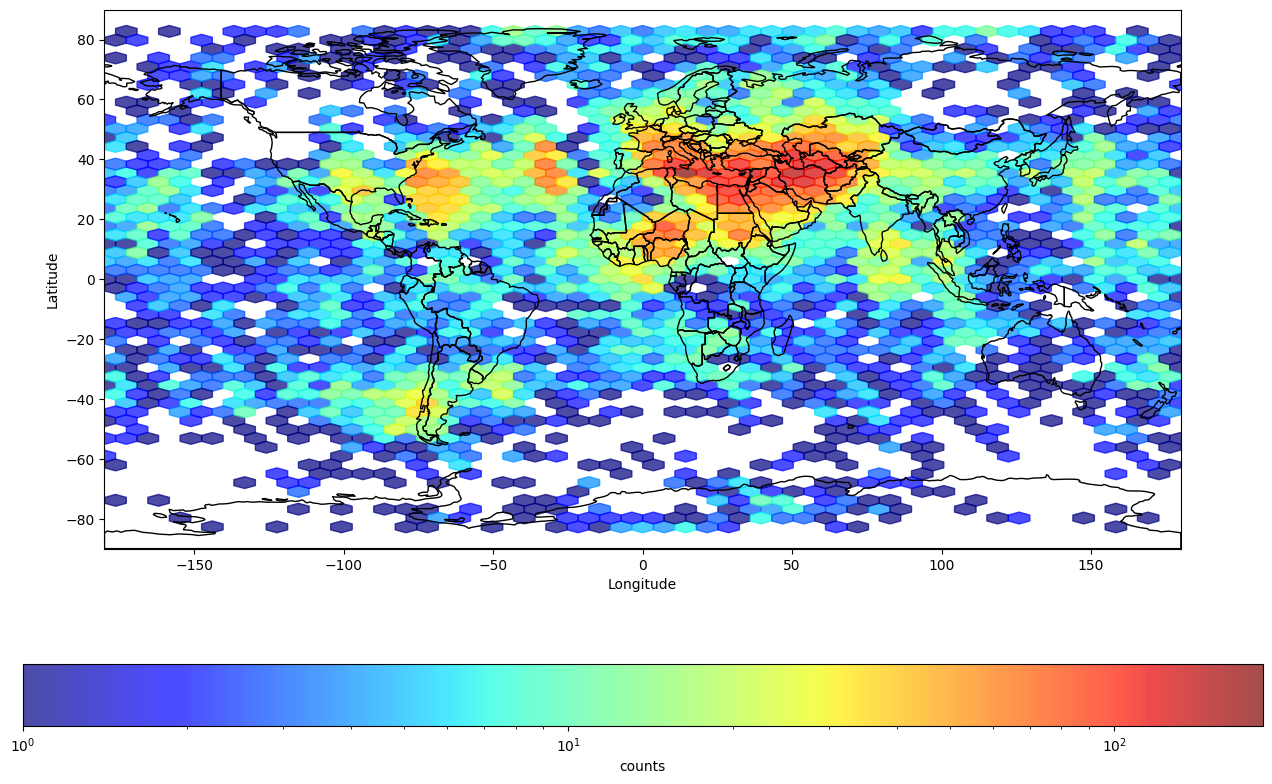

In [34]:
import geopandas as gpd

condition_val=2
#https://medium.com/@kavee625/plotting-data-on-the-world-map-with-geopandas-f03742615196
import matplotlib.pyplot as plt
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))

#worldmap.plot(color="lightgrey", ax=ax)

# Plotting tourist source markets
x = fs_dict['lon_m'][y_pred==condition_val]
y = fs_dict['lat_m'][y_pred==condition_val]
#z = df['spireid']

bins=np.logspace(0, 2, num=20)+5
bins='log'
hb = ax.hexbin(x, y, gridsize=50, bins=bins, mincnt=0,  cmap='jet', alpha=.7) #bins='log',
worldmap.plot(facecolor="none", ax=ax, edgecolor='black')

#plt.clim(5,100)
#ax.set(xlim=xlim, ylim=ylim)
#ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax, label='counts',location='bottom')
#base = worldmap.plot(color='white', edgecolor='black')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

#plt.title("Tourist arrivals from main countries to Sri Lanka\n  Year : 2021")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()